# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Image dimensions: (32, 32, 3)
Number of classes: 100


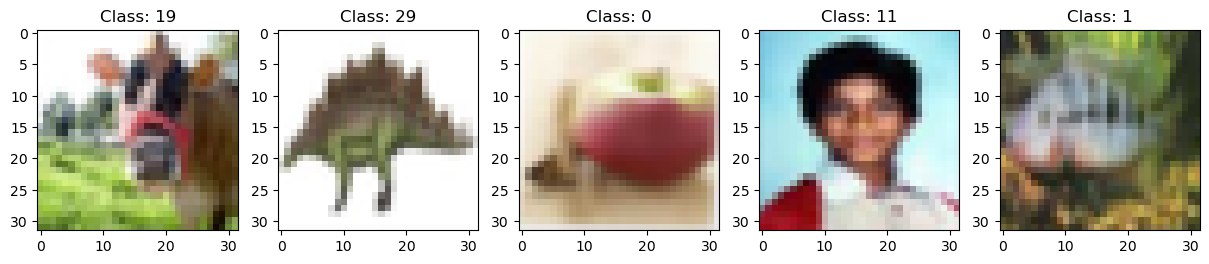

In [27]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt
# shape
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# dimension
print(f"Image dimensions: {X_train.shape[1:]}")

# number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")


# Display a few examples from the training set
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(X_train[i]) # X contains the image
    axes[i].set_title(f"Class: {y_train[i][0]}") # Y contains the labels

plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [3]:
# Your code here

# normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# print(f"Min value in training data: {X_train_normalized.min()}")
# print(f"Max value in training data: {X_train_normalized.max()}")
# print(f"Min value in test data: {X_test_normalized.min()}")
# print(f"Max value in test data: {X_test_normalized.max()}")



# one hot encode
from tensorflow.keras.utils import to_categorical
# print(f'Before one-hot encoding: {y_train[0]}')
y_train_one_hot = to_categorical(y_train, num_classes=100)
y_test_one_hot = to_categorical(y_test, num_classes=100)
# print(f'After one-hot encoding: {y_train[0]}')

# split into testing and validation
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42)


print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val_split.shape}")
print(f"Test data shape: {X_test.shape}")

print(f"Training labels shape: {y_train_split.shape}")
print(f"Validation labels shape: {y_val_split.shape}")
print(f"Test labels shape: {y_test_one_hot.shape}")

Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training labels shape: (40000, 100)
Validation labels shape: (10000, 100)
Test labels shape: (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Your code here

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(100, activation='softmax'))


# Print the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 4096)              0         
                                                                 
 dense_15 (Dense)            (None, 512)             

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [63]:
from keras import optimizers
from tensorflow.keras.metrics import Precision, Recall

# Your code here
model.compile(optimizer="adam", loss=['categorical_crossentropy'],
               metrics=['accuracy',Precision(), Recall()]) 

# Loss function: since we are working with one hot encoded data, categorical cross entrophy will help assess accuracy of the probability of the sample being part of one of the 100 classes
# Optimizer:  adam is a widely used algorithm for image classification

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [64]:
# Your code here

history = model.fit(
    X_train_split, y_train_split,
    batch_size=32, 
    epochs=15,  
    validation_data=(X_val_split, y_val_split),
    shuffle=True  # Shuffle the training data
)

Epoch 1/15
1250/1250 [==============================] - 78s 62ms/step - loss: 3.4281 - accuracy: 0.2043 - precision_7: 0.6056 - recall_7: 0.0543 - val_loss: 3.0555 - val_accuracy: 0.2741 - val_precision_7: 0.6322 - val_recall_7: 0.0961
Epoch 2/15
1250/1250 [==============================] - 68s 55ms/step - loss: 2.7078 - accuracy: 0.3369 - precision_7: 0.6775 - recall_7: 0.1500 - val_loss: 2.8102 - val_accuracy: 0.3225 - val_precision_7: 0.6547 - val_recall_7: 0.1513
Epoch 3/15
1250/1250 [==============================] - 90s 72ms/step - loss: 2.3287 - accuracy: 0.4193 - precision_7: 0.7242 - recall_7: 0.2336 - val_loss: 2.8884 - val_accuracy: 0.3257 - val_precision_7: 0.5918 - val_recall_7: 0.1866
Epoch 4/15
1250/1250 [==============================] - 92s 74ms/step - loss: 1.9618 - accuracy: 0.4980 - precision_7: 0.7540 - recall_7: 0.3275 - val_loss: 3.0984 - val_accuracy: 0.3091 - val_precision_7: 0.5243 - val_recall_7: 0.2032
Epoch 5/15
1250/1250 [==============================] - 

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [ ]:
# Your code here
'''
Accuracy improved with each epoch, reaching 0.8776 by epoch 15.
Accuracy represents the ratio of number of correct predictions to total number of predictions.
Based on accuracy, the model was able to predict correctly 87% of the time.

Precision and recall are measures we can use in case the sample classes are imbalanced. 
Precision refers to the number of true class classification from all classes that were identified as the class, regardless of correct or not.
Recall refers to the number of true class classification from all images that were from that class.


In our model, training performance is fairly good at around 88% and 87% but the validation precision and recall are not that great at 
around 28% and 25%.

'''

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

313/313 [==============================] - 4s 13ms/step


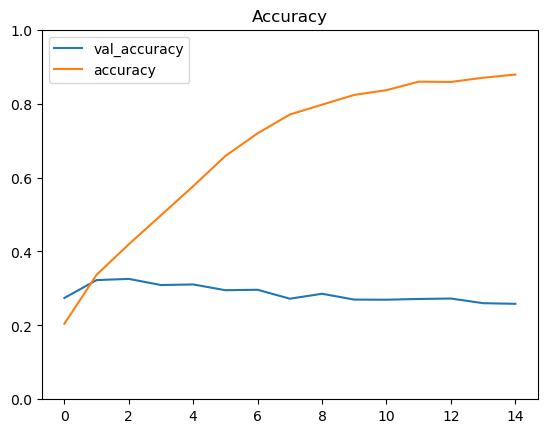

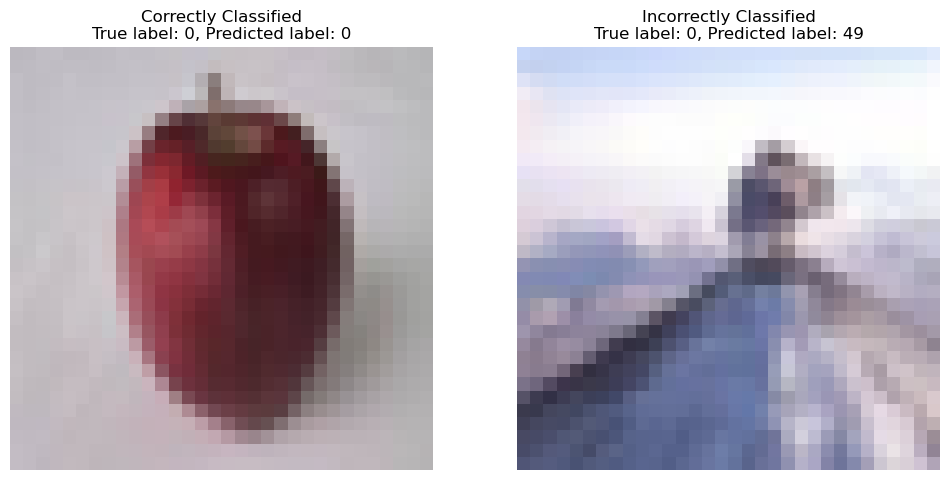

In [73]:
# Your code here
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.title('Accuracy');



# correctly classified image and incorrectly classified image
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
correct_indices = np.where(predicted_labels == true_labels)[0]
incorrect_indices = np.where(predicted_labels != true_labels)[0]


# Select one correct and one incorrect example
correct_index = correct_indices[0]
incorrect_index = incorrect_indices[0]

# Plot the correctly classified image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_test[correct_index])
plt.title(f"Correctly Classified\nTrue label: {true_labels[correct_index]}, Predicted label: {predicted_labels[correct_index]}")
plt.axis('off')

# Plot the incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(X_test[incorrect_index])
plt.title(f"Incorrectly Classified\nTrue label: {true_labels[incorrect_index]}, Predicted label: {predicted_labels[incorrect_index]}")
plt.axis('off')

plt.show()


## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [79]:
# Your code here

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Your code here

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(100, activation='softmax'))
model.add(Dropout(0.25))


# Print the model summary
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)        

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [80]:
# Your code here

model.compile(optimizer="adam", loss=['categorical_crossentropy'],
               metrics=['accuracy',Precision(), Recall()]) 

history = model.fit(
    X_train_split, y_train_split,
    batch_size=32, 
    epochs=15,  
    validation_data=(X_val_split, y_val_split),
    shuffle=True  # Shuffle the training data
)

Epoch 1/15
1250/1250 [==============================] - 74s 59ms/step - loss: 6.6837 - accuracy: 0.1105 - precision_8: 0.4267 - recall_8: 0.0212 - val_loss: 3.1870 - val_accuracy: 0.2357 - val_precision_8: 0.6956 - val_recall_8: 0.0425
Epoch 2/15
1250/1250 [==============================] - 67s 54ms/step - loss: 6.1309 - accuracy: 0.2112 - precision_8: 0.5333 - recall_8: 0.0802 - val_loss: 2.9329 - val_accuracy: 0.2803 - val_precision_8: 0.6992 - val_recall_8: 0.0702
Epoch 3/15
1250/1250 [==============================] - 71s 56ms/step - loss: 5.9726 - accuracy: 0.2486 - precision_8: 0.5615 - recall_8: 0.1168 - val_loss: 2.7989 - val_accuracy: 0.3119 - val_precision_8: 0.7385 - val_recall_8: 0.0960
Epoch 4/15
1250/1250 [==============================] - 69s 55ms/step - loss: 5.8743 - accuracy: 0.2712 - precision_8: 0.5617 - recall_8: 0.1416 - val_loss: 2.8299 - val_accuracy: 0.3050 - val_precision_8: 0.6562 - val_recall_8: 0.1065
Epoch 5/15
1250/1250 [==============================] - 

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

The model's performance on training data decreased and the recall resultsis showing that the model is not able to accurately classify images correctly to its correct class.
However, the validation results improved compared to the last model, which tells me that the model is not overfitting to the training data. However, the recall score is quite low.
This looks like a typical acse of balancing bias and variance where we are trying to have a model that is reasonable enough but isn't too accurate when looking at the training data.
I think we could potentially try larger kernel sizes, more layer, regularization and reduce the number of epoch, because the model doesn't seem to improve exponentially with more epochs. Maybe spending more time on identifying more appropriate initialization steps may be better.
Alternatively, if we can get higher quality images with more pixels, this could help as well in terms of training the data.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.